# NREL - NSRDB Multi-year Means HSDS Example

This notebook demonstrates data export from the National Renewable Energy Laboratory (NREL) Wind Integration National Dataset (WIND) Toolkit and National Solar Radiation Database (NSRDB) data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).

Please consult the README file for setup instructions prior to running this notebook.


In [1]:
%matplotlib inline
import h5pyd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import time

# Plotting settings
mpl.rcParams['font.sans-serif'] = 'DejaVu Sans'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16)
mpl.rc('font', size=16)

## NSRDB on AWS (via HSDS)

In [2]:
file_path = '/nrel/nsrdb/GOES/aggregated/v4.0.0/nsrdb_2017.h5'
with h5pyd.File(file_path, mode='r') as f:
    meta = pd.DataFrame(f['meta'][...])
    
meta.head()

,latitude,longitude,elevation,timezone,country,state,county
0,-15.950000,-179.979996,0,12,b'nan',b'nan',b'nan'
1,-15.990000,-179.979996,0,12,b'nan',b'nan',b'nan'
2,-16.030001,-179.979996,0,12,b'nan',b'nan',b'nan'
3,-16.070000,-179.979996,0,12,b'nan',b'nan',b'nan'
4,-16.110001,-179.979996,0,12,b'nan',b'nan',b'nan'


## Compute Multi-year GHI means for California

In [3]:
ca_meta = meta.loc[meta['state'] == b'California']
ca_pos = ca_meta.index.values.copy()
ca_slice = slice(ca_pos[0], ca_pos[-1] + 1)
ca_pos -= ca_pos[0]
down_size = 17520 * len(ca_pos) * 2 * 10**-6
ca_meta.head()
print('Number of NSRDB pixels in CA = {}'.format(len(ca_meta)))
print('Download size per year = {:.4f} MB'.format(down_size))

Number of NSRDB pixels in CA = 25981
Download size per year = 910.3742 MB


In [4]:
ca_df = ca_meta[['latitude', 'longitude']].copy()
ext_time = {}
ts = time.time()
for year in range(1998, 2018):
    col = '{}_means'.format(year)
    ty = time.time()
    file_path = '/nrel/nsrdb/GOES/aggregated/v4.0.0/nsrdb_{}.h5'.format(year)
    with h5pyd.File(file_path, mode='r') as f:
        ghi = f['ghi'][:, ca_slice]
    
    ca_df[col] = np.mean(ghi[:, ca_pos], axis=0)
    tt = time.time() - ty
    ext_time[str(year)] = tt
    print('Means for {} computed in {:.4f} minutes'.format(year, tt / 60))
    
tt = time.time() - ts
ext_time['total'] = tt
print('Time to extract all means =  {:.4f} hours'.format(tt / 3600))

Means for 1998 computed in 6.5375 minutes
Means for 1999 computed in 6.8774 minutes
Means for 2000 computed in 7.9718 minutes
Means for 2001 computed in 7.9195 minutes
Means for 2002 computed in 7.3381 minutes
Means for 2003 computed in 7.3758 minutes
Means for 2004 computed in 7.7249 minutes
Means for 2005 computed in 6.3965 minutes
Means for 2006 computed in 3.7180 minutes
Means for 2007 computed in 5.6898 minutes
Means for 2008 computed in 5.2359 minutes
Means for 2009 computed in 6.4926 minutes
Means for 2010 computed in 6.6403 minutes
Means for 2011 computed in 5.0389 minutes
Means for 2012 computed in 5.0919 minutes
Means for 2013 computed in 6.0336 minutes
Means for 2014 computed in 6.7182 minutes
Means for 2015 computed in 5.9692 minutes
Means for 2016 computed in 5.3730 minutes
Means for 2017 computed in 5.6344 minutes
Time to extract all means =  2.0963 hours


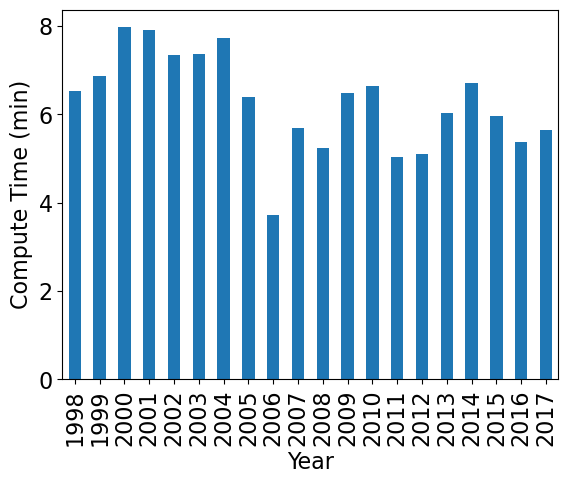

In [5]:
ext_df = pd.DataFrame(ext_time, index=['seconds']).T
ext_df['minutes'] = ext_df['seconds'] / 60
ext_df['hours'] = ext_df['seconds'] / 3600
ax = ext_df.iloc[:-1]['minutes'].plot.bar()
ax.set_xlabel('Year')
ax.set_ylabel('Compute Time (min)')
plt.show()

In [6]:
means_cols = [col for col in ca_df.columns
              if 'means' in col]
ca_df['MY means'] = ca_df[means_cols].mean(axis=1)
ca_df['CV'] = ca_df[means_cols].std(axis=1) / ca_df['MY means']
ca_df.head()

,latitude,longitude,1998_means,1999_means,2000_means,2001_means,2002_means,2003_means,2004_means,2005_means,...,2010_means,2011_means,2012_means,2013_means,2014_means,2015_means,2016_means,2017_means,MY means,CV
110930,40.490002,-124.379997,153.652968,162.320776,164.686589,171.747432,174.676598,175.890696,176.326617,166.624315,...,160.660217,168.985160,165.630977,191.650114,189.440068,186.353938,176.201332,173.435788,172.233878,0.054361
110931,40.450001,-124.379997,162.110731,175.458048,175.301343,180.321461,185.800970,182.921689,187.740608,178.835445,...,166.013299,173.454566,162.120617,186.737215,183.980023,185.495205,179.058060,177.361416,177.674498,0.042013
110932,40.410000,-124.379997,165.321632,173.988527,174.905112,181.998116,187.116781,181.538699,188.292748,177.505879,...,166.306678,173.900913,162.426742,187.394578,184.444007,185.975571,179.469661,177.803824,177.957376,0.041390
111362,40.570000,-124.339996,146.303881,157.010217,161.477288,166.544064,173.721005,170.375457,171.556182,160.831564,...,154.745091,164.430537,153.306751,177.436016,174.778253,175.422774,173.719718,169.627454,165.969270,0.049915
111363,40.529999,-124.339996,153.466096,159.151370,163.493340,167.848402,176.295548,174.314783,173.690175,171.599258,...,155.497089,165.086358,152.515084,177.005365,175.167066,175.602226,173.350922,170.097146,167.667895,0.045692


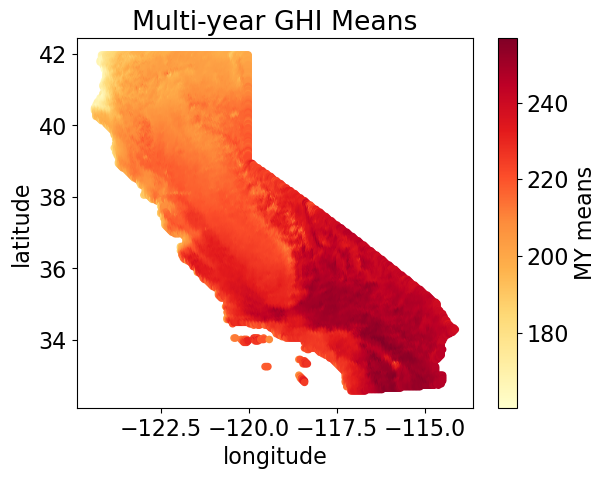

In [7]:
ax = ca_df.plot.scatter(x='longitude', y='latitude', c='MY means',
                colormap='YlOrRd',
                title='Multi-year GHI Means')
plt.show()

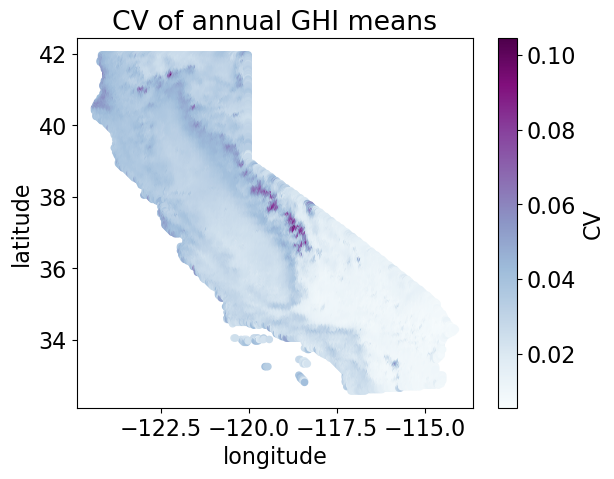

In [8]:
ca_df.plot.scatter(x='longitude', y='latitude', c='CV',
                colormap='BuPu',
                title='CV of annual GHI means')
plt.show()